In [68]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras import layers, Sequential
import  pandas_ta as ta

In [22]:
aapl = yf.download('AAPL','2013-01-01',datetime.now())


[*********************100%***********************]  1 of 1 completed


In [23]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791187,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579239,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117432,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022625,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065746,458707200


In [24]:
def train_test_plot(data, tstart, tend):
    data.loc[f'{tstart}':f'{tend}', 'High'].plot(figsize=(16,4), legend=True)
    data.loc[f'{tend +1}':, 'High'].plot(figsize=(16,4), legend=True)
    plt.legend([f'Train (before {tend+1})', f'Test ({tend+1} and beyond)'])
    plt.title('Apple Stock price')
    plt.show()

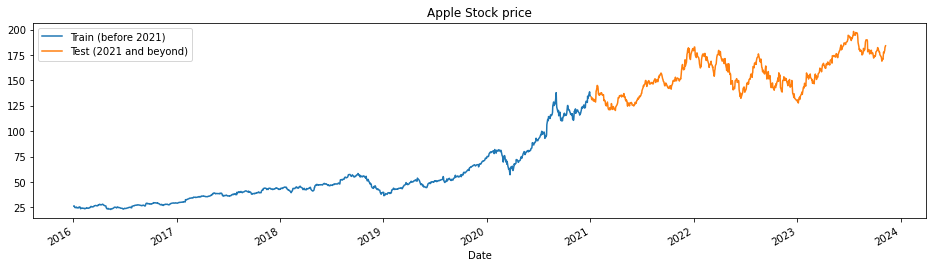

In [25]:
train_test_plot(aapl, 2016, 2020)

In [26]:
def train_test_split(data, tstart, tend, columns = ['High']):
    train = data.loc[f'{tstart}':f'{tend}', columns].values
    test = data.loc[f'{tend +1}':, columns].values
    
    return train, test

In [27]:
train_set, test_set = train_test_split(aapl, 2016, 2020)

In [28]:
train_set

array([[ 26.34250069],
       [ 26.46249962],
       [ 25.59250069],
       ...,
       [138.78999329],
       [135.99000549],
       [134.74000549]])

In [29]:
sc = MinMaxScaler(feature_range=(0,1))
train_set = train_set.reshape(-1, 1)
train_set_scaled = sc.fit_transform(train_set)

In [30]:
n_steps = 1
features = 1


In [31]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [32]:
train_X, train_y = split_sequence(train_set_scaled, n_steps)

In [33]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], features)

In [34]:
train_X

array([[[0.02955836]],

       [[0.03059397]],

       [[0.02308573]],

       ...,

       [[0.98748627]],

       [[1.        ]],

       [[0.97583561]]])

In [35]:
def plot_predictions(test, predicted, title):
    plt.plot(test, color='gray', label='Real')
    plt.plot(predicted, color='red', label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(title)
    plt.legend()
    plt.show()

## Vanila RNN Example


In [36]:
def plot_loss(history):
    plt.figure(figsize=(15,10) )
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='best')
    plt.show()

In [37]:
model_rnn = Sequential()
model_rnn.add(layers.SimpleRNN(units=125, input_shape=(n_steps, features)))
model_rnn.add(layers.Dense(units=1) )


In [38]:
model_rnn.compile(optimizer='RMSprop', loss='mse')

In [39]:
history = model_rnn.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)

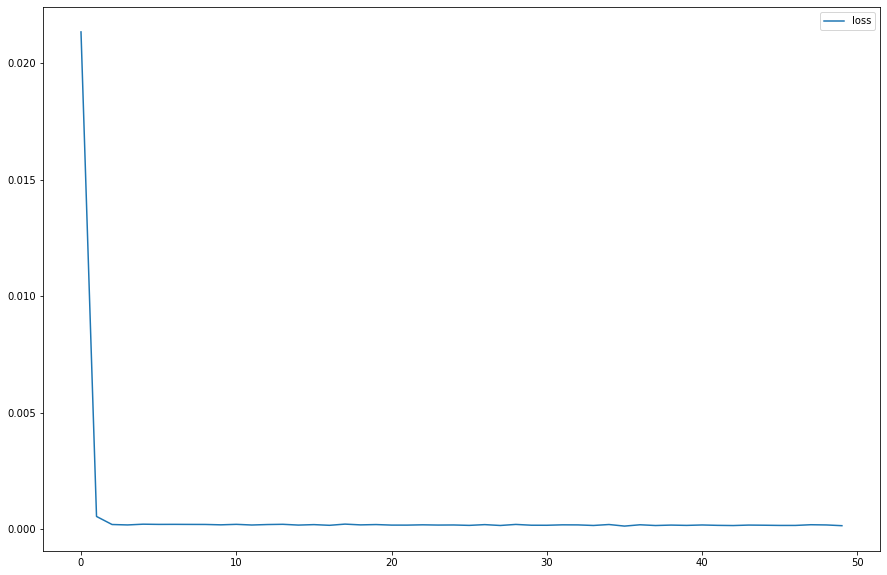

In [40]:
plot_loss(history)

- 

In [41]:
inputs = sc.transform(test_set.reshape(-1,1)) 


In [42]:
test_X, test_y = split_sequence(inputs, n_steps)
test_X = test_X.reshape(-1, n_steps, features)

In [43]:
predicted_stock_price = model_rnn.predict(test_X)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

23/23 [==============================] - 1s 4ms/step


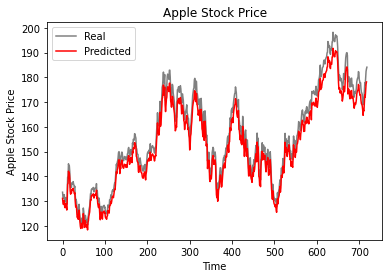

In [44]:
plot_predictions(test_set, predicted_stock_price, 'Apple Stock Price')

note: this is missleading 


## Sequence Generation

In [45]:
steps_in_future = 25

In [46]:
def sequence_generation(data: pd.DataFrame, sc: MinMaxScaler, model: Sequential, steps_future: int):
    high_data = data.iloc[len(data) - len(test_set) - n_steps:]['High']
    high_data = sc.transform(high_data.values.reshape(-1,1))
    inputs = high_data[:n_steps]
    
    for _ in range(steps_future):
        curr_period = model.predict(inputs[-n_steps:].reshape(-1,n_steps, features), verbose=0 )
        inputs = np.append(inputs, curr_period, axis=0)
    return sc.inverse_transform(inputs[n_steps:])

In [47]:
results = sequence_generation(aapl, sc, model_rnn, steps_in_future)

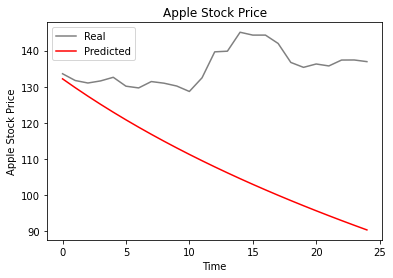

In [48]:
plot_predictions(test_set[:steps_in_future], results, 'Apple Stock Price')

In [49]:
model_lstm = Sequential()
model_lstm.add(layers.LSTM(units=125, input_shape=(n_steps, features)))
model_lstm.add(layers.Dense(units=1)) 


In [50]:
model_lstm.compile(optimizer='RMSprop', loss='mae')

In [51]:
history = model_lstm.fit(train_X, train_y, epochs=10, batch_size=32, verbose=0)

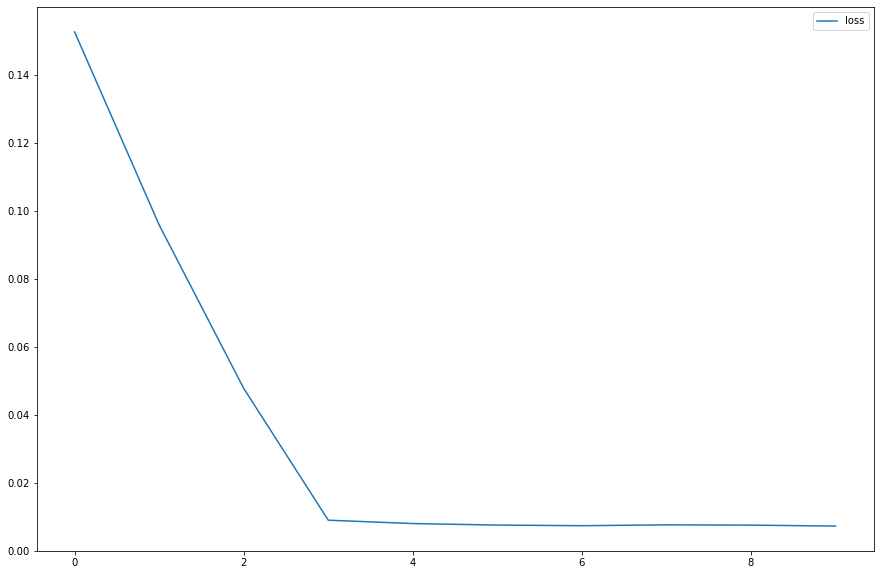

In [52]:
plot_loss(history)

In [53]:
predicted_stock_price = model_lstm.predict(test_X)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

23/23 [==============================] - 1s 3ms/step


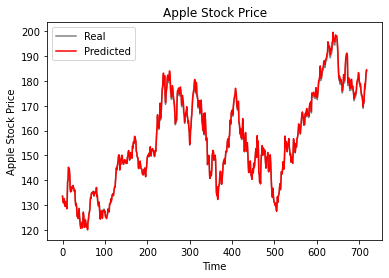

In [54]:
plot_predictions(test_set, predicted_stock_price, 'Apple Stock Price')

In [55]:
results = sequence_generation(aapl, sc, model_lstm, steps_in_future)

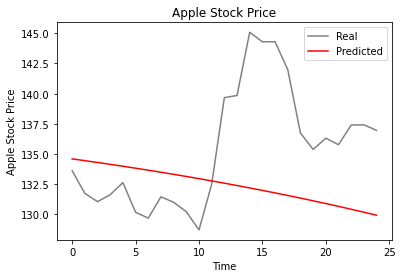

In [56]:
plot_predictions(test_set[:steps_in_future], results, 'Apple Stock Price')

In [57]:
variates_features = 6
multi_aapl = aapl.copy()

In [71]:
multi_aapl['RSI'] = ta.rsi(multi_aapl.Close, length=15)
multi_aapl['EMAF'] = ta.ema(multi_aapl.Close, length=20)
multi_aapl['EMAM'] = ta.ema(multi_aapl.Close, length=100)
multi_aapl['EMAS'] = ta.ema(multi_aapl.Close, length=150)


In [75]:
multi_aapl

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS
Date,,,,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791187,560518000,NaN,NaN,NaN,NaN
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579239,352965200,NaN,NaN,NaN,NaN
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117432,594333600,NaN,NaN,NaN,NaN
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022625,484156400,NaN,NaN,NaN,NaN
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065746,458707200,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-11-03,174.240005,176.820007,173.350006,176.649994,176.649994,79763700,53.929960,174.094877,176.504005,174.384907
2023-11-06,176.380005,179.429993,176.210007,179.229996,179.229996,63841300,58.314000,174.583936,176.557985,174.449080
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.820007,70530000,62.184530,175.273085,176.662183,174.546708


In [77]:
multi_aapl['Target'] = multi_aapl['Adj Close'] - multi_aapl.Open
multi_aapl['Target'] = multi_aapl['Target'].shift(-1)
multi_aapl.dropna(inplace=True)
multi_aapl.drop(['Volume', 'Close'], axis=1, inplace=True)

In [78]:
multi_aapl


,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target
Date,,,,,,,,,
2013-08-06,16.715000,16.853214,16.506071,14.406571,69.038240,15.848586,15.722364,15.912712,-2.166079
2013-08-07,16.564285,16.678572,16.491785,14.398207,68.764895,15.920761,15.739870,15.921900,-2.196894
2013-08-08,16.566429,16.575001,16.355356,14.369535,64.727822,15.972559,15.754222,15.929089,-2.214942
2013-08-09,16.379999,16.445000,16.201786,14.165057,58.633462,15.997112,15.763650,15.933079,-1.748964
2013-08-12,16.316429,16.737499,16.308214,14.567465,65.485540,16.063237,15.782022,15.943124,-1.559543
...,...,...,...,...,...,...,...,...,...
2023-11-02,175.520004,177.779999,175.460007,177.570007,55.886096,173.825917,176.501056,174.354503,2.409988
2023-11-03,174.240005,176.820007,173.350006,176.649994,53.929960,174.094877,176.504005,174.384907,2.849991
2023-11-06,176.380005,179.429993,176.210007,179.229996,58.314000,174.583936,176.557985,174.449080,2.640015


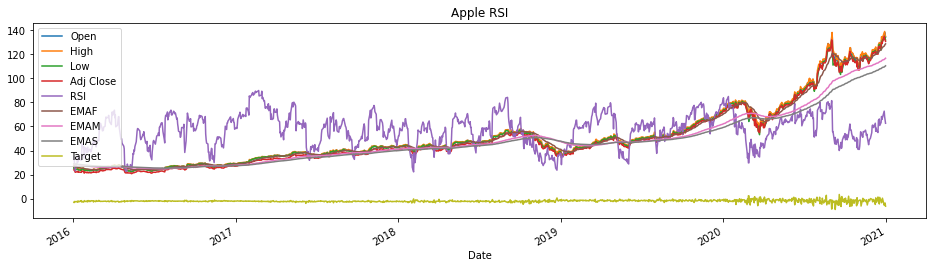

In [80]:
tstart, tend = 2016, 2020
multi_aapl.loc[f'{tstart}':f'{tend}'].plot(figsize=(16,4), legend=True)
plt.title('Apple RSI')
plt.show()

In [81]:
feat_columns = ['Open', 'High', 'RSI', 'EMAF', 'EMAM', 'EMAS']
labels_cols = ['Target']

In [82]:
training_set, test_set = train_test_split(multi_aapl, tstart, tend, feat_columns+labels_cols)


In [83]:
X_train = training_set[:, :-1]
y_train = training_set[:, -1]

X_test = test_set[:, :-1]
y_test = test_set[:, -1]


In [85]:
multi_sc = MinMaxScaler(feature_range=(0,1))
X_train = multi_sc.fit_transform(X_train).reshape(-1,1, variates_features)
X_test = multi_sc.fit_transform(X_test).reshape(-1,1, variates_features)

In [92]:
model_multi = Sequential()
model_multi.add(layers.LSTM(units=125, input_shape=(1, variates_features)))
model_multi.add(layers.Dense(units=1))
model_multi.compile(optimizer='RMSprop', loss='mae')

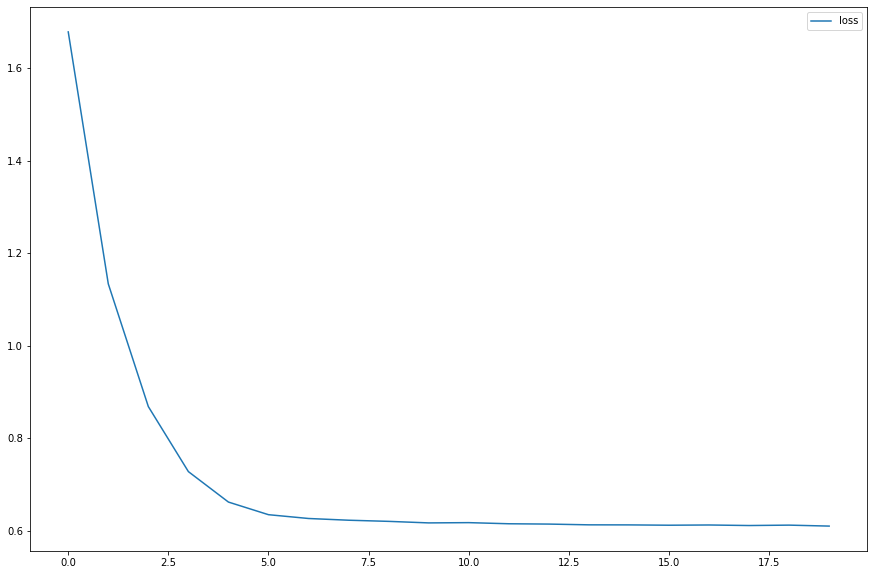

In [93]:
history = model_multi.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
plot_loss(history)

23/23 [==============================] - 0s 2ms/step


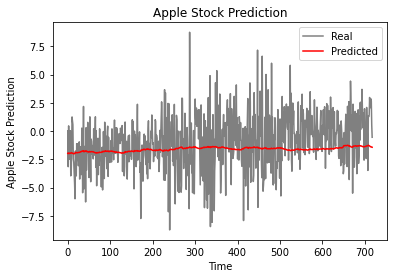

In [94]:
predictions = model_multi.predict(X_test)
plot_predictions(y_test, predictions, title='Apple Stock Prediction')
